<h3>Analyzing wireshark pcap file using scapy.</h3>
<p>> Load the pcap file as a scapy object.</p>
<p>> Iterate each packet, extract time stamp, size in bytes and the fields from each layer.</p>
<p>> Convert the packets to a pandas DataFrame.</p>

<h4>Import required resources.</h4>

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
from scapy.all import *

%matplotlib inline

<h4>Setup global variables.</h4>
<p><b>path: </b>The path to the pcap file to use.</p>
<p><b>pcap: </b>Use rdpcap() to load the pcap file in to <i>Scapy</i></p>

In [118]:
path = './facebook.com_clean.pcapng'
pcap = rdpcap(path)

__ = list()


<h4>Iterate the <i>Scapy</i> pcap data.</h4>
<p>Create a <i>dict</i> from each <i>scapy</i> layer.</p>
<p>Each layer field will be a column in the subsequent <i>pandas DataFrame.</i></p>
<p>Each packet will be a row.</p>


In [123]:
for packet in pcap:
  _ = dict()

  _['timestamp'] = packet.time - pcap[0].time

  # If the packet has an Ether layer add the
  # src the dst column to the dict,
  # src and dst will be maped to 'www.facebook.com'
  # and 'Client host' based on their MAC.
  if packet.haslayer(scapy.layers.l2.Ether):
    for field in list(packet['Ether'].fields.items()):
      if field[0] == 'src':
        if field[1] == 'a0:ab:1b:59:28:e6':
            _['src'] = 'facebook.com'
            _['dst'] = 'Client host'
        elif field[1] == 'e0:94:67:c5:af:21':
            _['src'] = 'Client host'
            _['dst'] = 'facebook.com'
      else:
            _['Ether.' + field[0]] = field[1]

  # If the packet has an IP layer add all
  # IP data: address, option, flags...
  if packet.haslayer(scapy.layers.inet.IP):
    for field in list(packet['IP'].fields.items()):
      if field[0] == 'options':
        for option in field[1]:
          _['IP.options.' + option[0]] = option[1]
      elif field[0] == 'flags':
        _['IP.' + field[0]] = field[1].flagrepr()
      else:
        _['IP.' + field[0]] = field[1]

  # If the packet has a TCP layer add all
  # TCP data: address, option, flags...
  # Adjust sequence and ack numbers
  # to show relative numbers.
  if packet.haslayer(scapy.layers.inet.TCP):
    for field in list(packet['TCP'].fields.items()):
      if field[0] == 'options':
        for option in field[1]:
          _['TCP.options.' + option[0]] = option[1]
      elif field[0] == 'flags':
        _['TCP.' + field[0]] = field[1].flagrepr()
      elif field[0] == 'seq':
        if packet['IP'].src == '192.168.1.6':
          _['TCP.' + field[0]] = field[1] - 2357798585
        elif packet['IP'].src == '157.240.1.35':
          _['TCP.' + field[0]] = field[1] - 3619121408
      elif field[0] == 'ack':
        if packet['IP'].src == '192.168.1.6':
            if 'S' in packet['TCP'].flags.flagrepr():
              _['TCP.' + field[0]] = 0
            else:
              _['TCP.' + field[0]] = field[1] - 3619121408
        elif packet['IP'].src == '157.240.1.35':
          _['TCP.' + field[0]] = field[1] - 2357798585
      else:
        _['TCP.' + field[0]] = field[1]

  # If the packet has a Raw layer add
  # Raw data and size.
  if packet.haslayer(scapy.packet.Raw):
    _['Raw.load'] = packet['Raw'].load
    _['Raw.load.size'] = len(packet['Raw'].load)
  else:
    _['Raw.load.size'] = 0

  __.append(_)

<h3>Data table</h3>
<p>A table summarizing the pandas DataFrame</p>
<p>sorted by timestamp, the table shows the progress of ack numbers and squence numbers to and from the web site.</p>

In [124]:
pcap_df = pd.DataFrame(__).sort_values('timestamp')
pcap_df[['timestamp', 'src', 'dst', 'TCP.flags', 'TCP.ack', 'TCP.seq', 'Raw.load.size']]

,timestamp,src,dst,TCP.flags,TCP.ack,TCP.seq,Raw.load.size
0,0.000000,Client host,facebook.com,S,0,0,0
353,0.000000,Client host,facebook.com,S,0,0,0
354,0.745780,facebook.com,Client host,SA,1,0,0
1,0.745780,facebook.com,Client host,SA,1,0,0
2,0.745853,Client host,facebook.com,A,1,1,0
355,0.745853,Client host,facebook.com,A,1,1,0
3,0.746624,Client host,facebook.com,PA,1,1,517
356,0.746624,Client host,facebook.com,PA,1,1,517
4,2.009379,facebook.com,Client host,A,518,1,0
357,2.009379,facebook.com,Client host,A,518,1,0


<h3>facebook.com</h3>
<p>Plots the sequence numbers as a function of elapsed time.</p>

Text(0, 0.5, 'Sequence number')

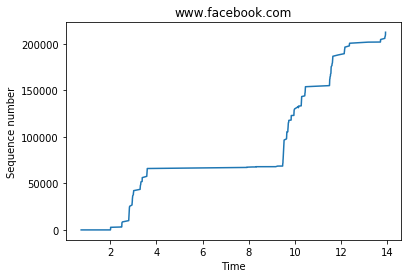

In [116]:
x = pcap_df['timestamp'][pcap_df['src'] == 'facebook.com']
y = pcap_df['TCP.seq'][pcap_df['src'] == 'facebook.com']

plt.plot(x, y)
plt.title('www.facebook.com')
plt.xlabel('Time')
plt.ylabel('Sequence number')

<h3>Client host</h3>
<p>Plots the sequence numbers as a function of elapsed time.</p>

Text(0, 0.5, 'Sequence number')

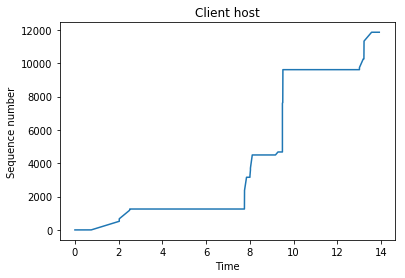

In [117]:
x = pcap_df['timestamp'][pcap_df['src'] == 'Client host']
y = pcap_df['TCP.seq'][pcap_df['src'] == 'Client host']

plt.plot(x, y)
plt.title('Client host')
plt.xlabel('Time')
plt.ylabel('Sequence number')